# Post Differential Methylation Analysis

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gseapy as gp
from gseapy import Biomart, enrichment_map
from gseapy.plot import barplot, dotplot, gseaplot

In [2]:
PATH = "/home/cschuster/Projects/Bio-IT-VIB/"

## Data Loading and Functions

In [37]:
def enrich(gene_list):
    enr = gp.enrichr(gene_list = gene_list,
                 gene_sets = ["MSigDB_Hallmark_2020", "GO_Biological_Process_2023", "KEGG_2019_Mouse"], 
                 organism = "human",
                 outdir = None)
    return enr

In [48]:
def dot_plot(enr, title, figsize, s):
    ax = dotplot(enr, column = "Adjusted P-value",
                 xticklabels_rot = 15, cmap=plt.cm.cool,
                 x = "Gene_set", size = s,
                 top_term = 20, figsize = figsize,
                 title = title, cutoff = 0.05,
                 show_ring = True, marker = "o")
    return ax

Let's load the bulk data and simplify the sample names

In [3]:
bulk_data = pd.read_csv(f"{PATH}/Data/bulk_samples.csv", index_col=0)
new_colnames = list(bulk_data.columns)
new_colnames = [id.split("_")[0] for id in new_colnames]
bulk_data.columns = new_colnames
bulk_data

,GSM1052046,GSM1051753,GSM1052111,GSM1052007,GSM1051948,GSM1052043,GSM1051566,GSM1051939,GSM1051533,GSM1051613,...,GSM1051804,GSM1052213,GSM1051527,GSM1051602,GSM1051747,GSM1051755,GSM1051851,GSM1052037,GSM1051989,GSM1051761
CpGs,,,,,,,,,,,,,,,,,,,,,
cg26930596,0.345281,0.429527,0.366898,0.286082,0.244029,0.227953,0.370236,0.151721,0.438302,0.239145,...,0.440429,0.487776,0.218955,0.405363,0.330680,0.381894,0.365790,0.505487,0.130340,0.537773
cg08884752,0.804490,0.588899,0.680630,0.729852,0.837841,0.855354,0.628293,0.714503,0.678508,0.753003,...,0.618792,0.574934,0.806466,0.670479,0.699720,0.650543,0.620594,0.819819,0.836851,0.541566
cg26160564,0.764194,0.797626,0.905513,0.888256,0.969087,0.860470,0.845501,0.927306,0.766948,0.926865,...,0.837257,0.834544,0.915210,0.874978,0.922421,0.885134,0.891857,0.722543,0.902199,0.846609
cg01024458,0.959898,0.974212,0.963914,0.976108,0.968388,0.956077,0.955908,0.968160,0.954907,0.985184,...,0.973776,0.922287,0.971049,0.982491,0.966653,0.965391,0.969678,0.962965,0.979680,0.938864
cg13785123,0.505338,0.502080,0.570013,0.420020,0.293635,0.382621,0.413670,0.271397,0.509340,0.342881,...,0.618609,0.575102,0.295395,0.447203,0.313354,0.497702,0.489722,0.682124,0.237533,0.531504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg00156057,0.906375,0.854169,0.907594,0.905658,0.874830,0.919414,0.913981,0.912504,0.899146,0.896106,...,0.878528,0.847456,0.887761,0.887188,0.893545,0.868467,0.863025,0.892731,0.864525,0.871352
cg11414202,0.671586,0.623264,0.558246,0.593576,0.603116,0.554740,0.568572,0.548141,0.630713,0.556378,...,0.648267,0.625405,0.548249,0.501929,0.537822,0.523433,0.584360,0.654629,0.598805,0.609670
cg16144293,0.034953,0.030970,0.037165,0.022259,0.028125,0.016613,0.036890,0.034204,0.028572,0.017359,...,0.020533,0.044234,0.026896,0.026603,0.029495,0.031132,0.023033,0.026294,0.035084,0.017036


Now we also load the differentially methylated genes and their annotations that we obtained from the Rscript

In [5]:
treat12 = pd.read_csv(f"{PATH}/Outputs/treat12_annot.csv", index_col=0)
treat13 = pd.read_csv(f"{PATH}/Outputs/treat13_annot.csv", index_col=0)
treat23 = pd.read_csv(f"{PATH}/Outputs/treat23_annot.csv", index_col=0)

In [13]:
cpg_clust_colors = pd.read_csv(f"{PATH}/Outputs/cpg_clust_colors.csv", index_col=0)
cpg_clust_colors

,Color
0,red
1,blue
2,blue
3,blue
4,red
...,...
495,green
496,red
497,green
498,green


Do the DMGs correlate with the clusters we had determine before?

## Correlation between CpG clusters and DMGs

/home/cschuster/py3ws/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/cschuster/py3ws/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


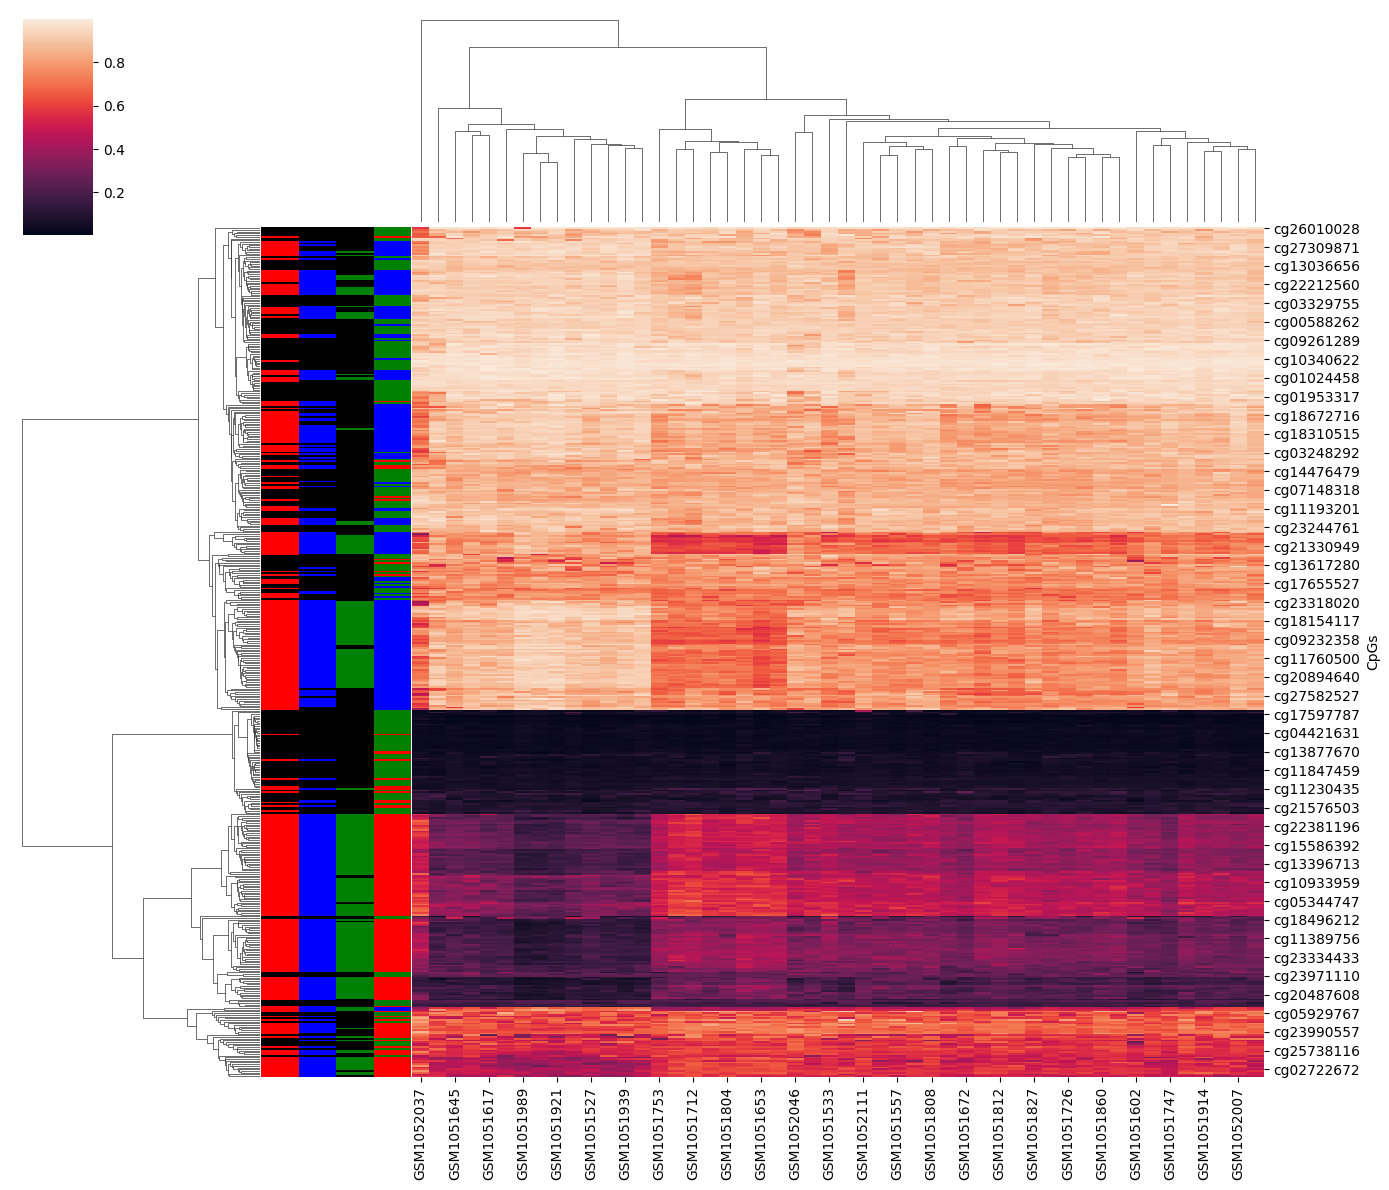

In [61]:
colors12 = ["red" if k in treat12.index else "black" for k in bulk_data.index]
colors13 = ["blue" if k in treat13.index else "black" for k in bulk_data.index]
colors23 = ["green" if k in treat23.index else "black" for k in bulk_data.index]
clust_colors = list(cpg_clust_colors.Color)
cg = sns.clustermap(bulk_data, row_colors = [colors12, colors13, colors23, clust_colors], figsize=(14,12))
plt.savefig(f"{PATH}/Outputs/Figures/cpgs_DMGs.png", dpi=300, bbox_inches="tight")
plt.show()

Apparently not, although it seems that the green cluster was mainly genes that were not significant to any of the contrasts we did. Perhaps a Venn diagram can help clarify?

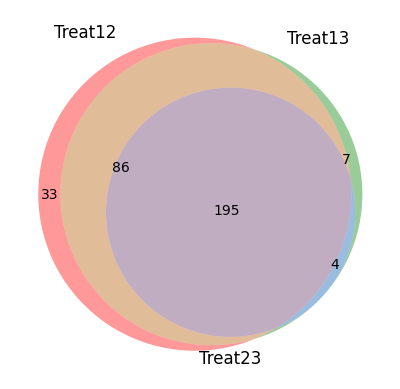

In [22]:
venn3([set(treat12.index), set(treat13.index), set(treat23.index)], ["Treat12", "Treat13", "Treat23"])
plt.show()

In summary, all DMGs are basically the same for each contrast

## Enrichment Analysis

We need to generate sets with the gene symbols for each contrast

In [41]:
gene_list12 = []
for k in list(treat12.UCSC_RefGene_Name):
    if type(k)==str:
        gene_list12 += k.split(";")

gene_list12 = set(gene_list12)

gene_list13 = []
for k in list(treat13.UCSC_RefGene_Name):
    if type(k)==str:
        gene_list13 += k.split(";")

gene_list13 = set(gene_list13)

gene_list23 = []
for k in list(treat23.UCSC_RefGene_Name):
    if type(k)==str:
        gene_list23 += k.split(";")

gene_list23 = set(gene_list23)

Now we run the enrichment function

In [42]:
enr12 = enrich(list(gene_list12)).results
enr13 = enrich(list(gene_list13)).results
enr23 = enrich(list(gene_list23)).results

And filter for significance with p-Val < 0.05

In [45]:
enr12_sig = enr12[enr12["Adjusted P-value"]<0.05]
enr13_sig = enr13[enr13["Adjusted P-value"]<0.05]
enr23_sig = enr23[enr23["Adjusted P-value"]<0.05]

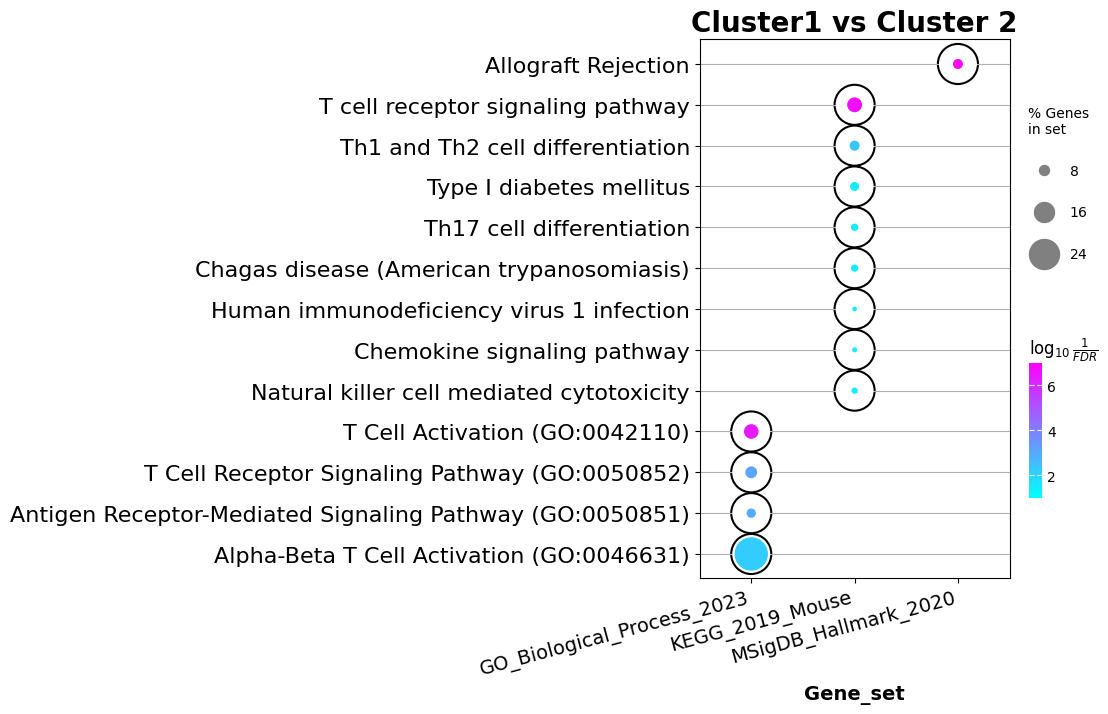

In [62]:
a = dot_plot(enr12_sig, "Cluster1 vs Cluster 2", (5,7), 15)
plt.savefig(f"{PATH}/Outputs/Figures/enr12.png", dpi=300, bbox_inches="tight")
plt.show()

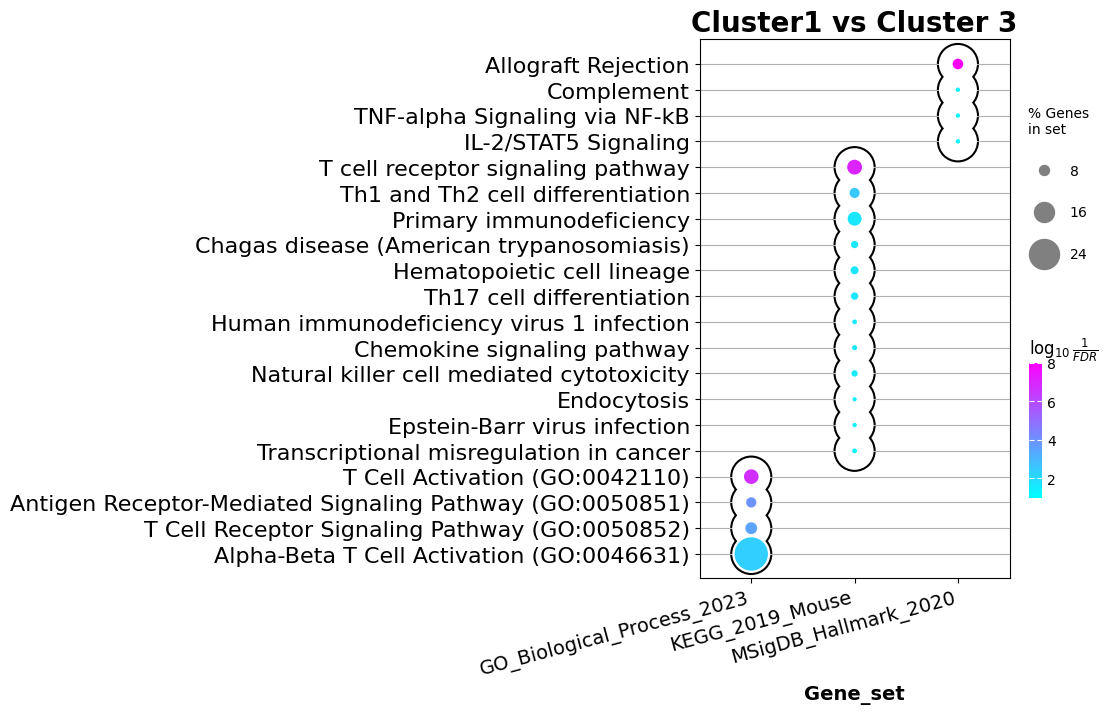

In [63]:
a = dot_plot(enr13_sig, "Cluster1 vs Cluster 3", (5,7), 15)
plt.savefig(f"{PATH}/Outputs/Figures/enr13.png", dpi=300, bbox_inches="tight")
plt.show()

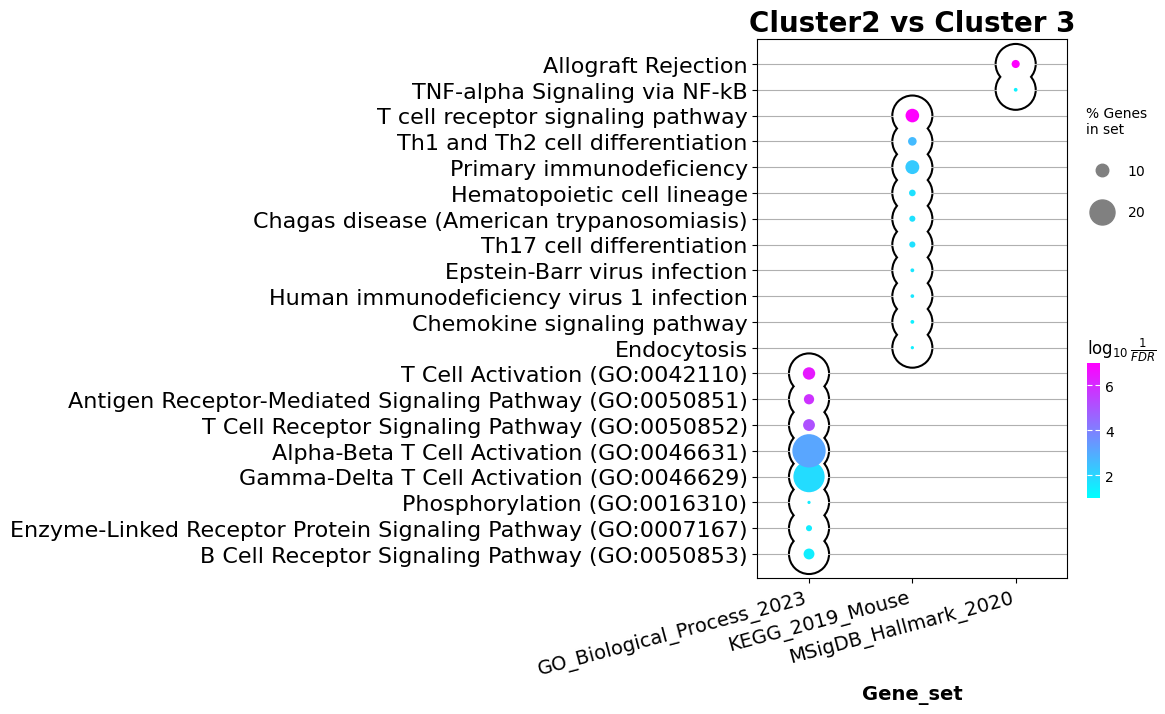

In [64]:
a = dot_plot(enr23_sig, "Cluster2 vs Cluster 3", (5,7), 15)
plt.savefig(f"{PATH}/Outputs/Figures/enr23.png", dpi=300, bbox_inches="tight")
plt.show()

We can see that overall, the terms are pretty much all the same in each contrast, which makes sense considering that the DMGs are almost the same too